## Load Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples



In [2]:
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
    summary['Data type'] = df.dtypes.values
    summary = summary.merge(df.describe().transpose().reset_index(), on = "index",how="left")

    return summary


In [3]:
def jaccard_similarity_continuous_rows_df(df, idx1, idx2):
    """
    Compute the Jaccard similarity coefficient for continuous data between two rows in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    idx1 (int): Index of the first row.
    idx2 (int): Index of the second row.

    Returns:
    float: Jaccard similarity coefficient.
    """
    import numpy as np

    # Extract the values of the two rows
    x = df.iloc[idx1].values
    y = df.iloc[idx2].values

    # Calculate intersection and union
    intersection = np.minimum(x, y).sum()
    union = np.maximum(x, y).sum()

    # Return Jaccard similarity coefficient
    return intersection / union if union != 0 else 0

def analyze_web_similarity(df, n_similar=5, standardize=False):
    """
    Analyzuje podobnost webových stránek na základě jejich features.
    
    # Provedení analýzy
    results = analyze_web_similarity(df)

    # Vizualizace výsledků
    visualize_similarities(results)
    
    Parameters:
    df: DataFrame s názvy webů v prvním sloupci a features v dalších sloupcích
    n_similar: Počet podobných stránek k zobrazení pro každou stránku
    
    Returns:
    dict: Slovník s různými metrikami podobnosti a analýzami
    """
    # Oddělení názvů a features
    websites = df.iloc[:, 0]
    features = df.iloc[:, 1:]
    
    # # Standardizace features
    if standardize:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    else:
        features_scaled = features
    
    # 1. Kosinová podobnost
    cosine_sim = cosine_similarity(features_scaled)
    
    # 2. Euklidovská vzdálenost
    euclidean_dist = squareform(pdist(features_scaled, 'euclidean'))
    
    # Vytvoření dictionary pro každou webovou stránku s jejími nejpodobnějšími protějšky
    similarity_dict = {}
    for i, website in enumerate(websites):
        # Najdeme nejpodobnější stránky (kromě sebe sama)
        similar_indices = cosine_sim[i].argsort()[::-1][1:n_similar+1]
        similar_websites = [
            {
                'web': websites.iloc[idx],
                'cosine_similarity': cosine_sim[i][idx],
                'euclidean_distance': euclidean_dist[i][idx],
                "jaccard_sim" : jaccard_similarity_continuous_rows_df(features, i, idx)
            }
            for idx in similar_indices
        ]
        similarity_dict[website] = similar_websites
    
    # Základní statistiky features
    feature_stats = {
        'correlation_matrix': features.corr(),
        'feature_importance': np.std(features_scaled, axis=0),
        'feature_names': features.columns
    }
    
    return {
        'similarity_dict': similarity_dict,
        'cosine_similarity_matrix': cosine_sim,
        'euclidean_distance_matrix': euclidean_dist,
        'feature_stats': feature_stats
    }

def visualize_similarities(analysis_results, n_clusters=10):
    """
    Vizualizuje výsledky analýzy podobnosti.
    """
    # Vytvoření heat mapy korelací features
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        analysis_results['feature_stats']['correlation_matrix'],
        cmap='coolwarm',
        center=0,
        annot=False
    )
    plt.title('Korelační matice features')
    plt.tight_layout()
    
    # Vytvoření grafu důležitosti features
    plt.figure(figsize=(12, 6))
    feature_importance = pd.Series(
        analysis_results['feature_stats']['feature_importance'],
        index=analysis_results['feature_stats']['feature_names']
    )
    feature_importance.sort_values(ascending=True).plot(kind='barh')
    plt.title('Důležitost jednotlivých features')
    plt.xlabel('Standardizovaná směrodatná odchylka')
    plt.tight_layout()

In [4]:
data = pd.read_csv('sites_embedding.csv')

In [5]:
data.head()

,site,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,...,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24
0,redditmlbstreams.live,0.00065,0.047358,0.000415,0.000000,0.020111,0.000666,0.000000,0.000000,0.112471,...,0.0,0.000000,0.001137,0.001781,0.003503,0.000000,0.000874,0.784522,0.003230,0.000270
1,ladysavings.com,0.00000,0.001403,0.002369,0.001033,0.000727,0.291403,0.001046,0.629109,0.001919,...,0.0,0.000000,0.012859,0.002759,0.002011,0.000000,0.000193,0.000000,0.002875,0.000000
2,petcarerx.com,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000157,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.999504,0.000000,0.000066,0.000274,0.000000,0.000000
3,govx.com,0.00000,0.006618,0.020445,0.000000,0.003382,0.023401,0.016749,0.013367,0.004601,...,0.0,0.026822,0.030462,0.001754,0.003209,0.007286,0.004858,0.709723,0.028343,0.017201
4,texassports.com,0.00000,0.000292,0.000000,0.000000,0.000000,0.000421,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.004519,0.000000,0.000000,0.066434,0.928334,0.000000,0.000000


In [6]:
summary_data = description(data)
summary_data


Dataset Shape: (4298, 25)


,index,dtypes,Name,Missing,PercMissing,Uniques,Data type,count,mean,std,min,25%,50%,75%,max
0,site,object,site,0,0.0,4298,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F_1,float64,F_1,0,0.0,1190,float64,4298.0,0.001787,0.010403,0.0,0.000000,0.000000,0.000484,0.247244
2,F_2,float64,F_2,0,0.0,3514,float64,4298.0,0.020845,0.045671,0.0,0.000439,0.002788,0.016877,0.447237
3,F_3,float64,F_3,0,0.0,3190,float64,4298.0,0.017037,0.036319,0.0,0.000257,0.004059,0.017894,0.416490
4,F_4,float64,F_4,0,0.0,2198,float64,4298.0,0.006648,0.022044,0.0,0.000000,0.000682,0.005008,0.363324
5,F_5,float64,F_5,0,0.0,3758,float64,4298.0,0.016894,0.038871,0.0,0.000684,0.003770,0.014373,0.431599
6,F_6,float64,F_6,0,0.0,3333,float64,4298.0,0.019237,0.039213,0.0,0.000687,0.004130,0.018647,0.388256
7,F_7,float64,F_7,0,0.0,3081,float64,4298.0,0.088167,0.241905,0.0,0.000000,0.003375,0.017078,0.997308
8,F_8,float64,F_8,0,0.0,2778,float64,4298.0,0.154643,0.326244,0.0,0.000000,0.002394,0.027056,1.000000
9,F_9,float64,F_9,0,0.0,1404,float64,4298.0,0.009034,0.035238,0.0,0.000000,0.000000,0.002758,0.481241


In [7]:
data_tranformed = data.copy()
for col in data.columns[1:]:
    data_tranformed[col + "_transformed"], fitted_lambda = stats.boxcox(data_tranformed[col] + 1)
    print(f"Column {col} transformed with lambda {fitted_lambda}")

data_tranformed = data_tranformed.drop(columns=data.columns[1:25])

Column F_1 transformed with lambda -414.8631048376708


Column F_2 transformed with lambda -40.6681708102279
Column F_3 transformed with lambda -44.94951611469284
Column F_4 transformed with lambda -115.41622472292957
Column F_5 transformed with lambda -47.6350234651398
Column F_6 transformed with lambda -41.925936028842635
Column F_7 transformed with lambda -13.465354255946123
Column F_8 transformed with lambda -8.289913486199762
Column F_9 transformed with lambda -89.49308206953033
Column F_10 transformed with lambda -11.900638963134167
Column F_11 transformed with lambda -73.10518520348514
Column F_12 transformed with lambda -78.68941931049919
Column F_13 transformed with lambda -83.56271519275478
Column F_14 transformed with lambda -94.95179545684586
Column F_15 transformed with lambda -232.32664845120064
Column F_16 transformed with lambda -74.70709687411977
Column F_17 transformed with lambda -88.73680066596617
Column F_18 transformed with lambda -25.594751245767014
Column F_19 transformed with lambda -25.292545966903628
Column F_20 t

In [8]:
summary_data_transf = description(data_tranformed)
summary_data_transf

Dataset Shape: (4298, 25)


,index,dtypes,Name,Missing,PercMissing,Uniques,Data type,count,mean,std,min,25%,50%,75%,max
0,site,object,site,0,0.0,4298,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F_1_transformed,float64,F_1_transformed,0,0.0,1180,float64,4298.0,0.000390,0.000716,0.0,0.000000,0.000000,0.000439,0.002410
2,F_2_transformed,float64,F_2_transformed,0,0.0,3514,float64,4298.0,0.006982,0.008400,0.0,0.000435,0.002632,0.012140,0.024589
3,F_3_transformed,float64,F_3_transformed,0,0.0,3190,float64,4298.0,0.006726,0.007289,0.0,0.000256,0.003703,0.012223,0.022247
4,F_4_transformed,float64,F_4_transformed,0,0.0,2198,float64,4298.0,0.002180,0.002878,0.0,0.000000,0.000656,0.003796,0.008664
5,F_5_transformed,float64,F_5_transformed,0,0.0,3758,float64,4298.0,0.006179,0.006662,0.0,0.000673,0.003445,0.010355,0.020993
6,F_6_transformed,float64,F_6_transformed,0,0.0,3333,float64,4298.0,0.007312,0.007915,0.0,0.000677,0.003785,0.012859,0.023852
7,F_7_transformed,float64,F_7_transformed,0,0.0,3081,float64,4298.0,0.014684,0.023550,0.0,0.000000,0.003294,0.015142,0.074258
8,F_8_transformed,float64,F_8_transformed,0,0.0,2778,float64,4298.0,0.027041,0.044868,0.0,0.000000,0.002368,0.023948,0.120243
9,F_9_transformed,float64,F_9_transformed,0,0.0,1404,float64,4298.0,0.001962,0.003399,0.0,0.000000,0.000000,0.002441,0.011174


<Axes: xlabel='Name'>

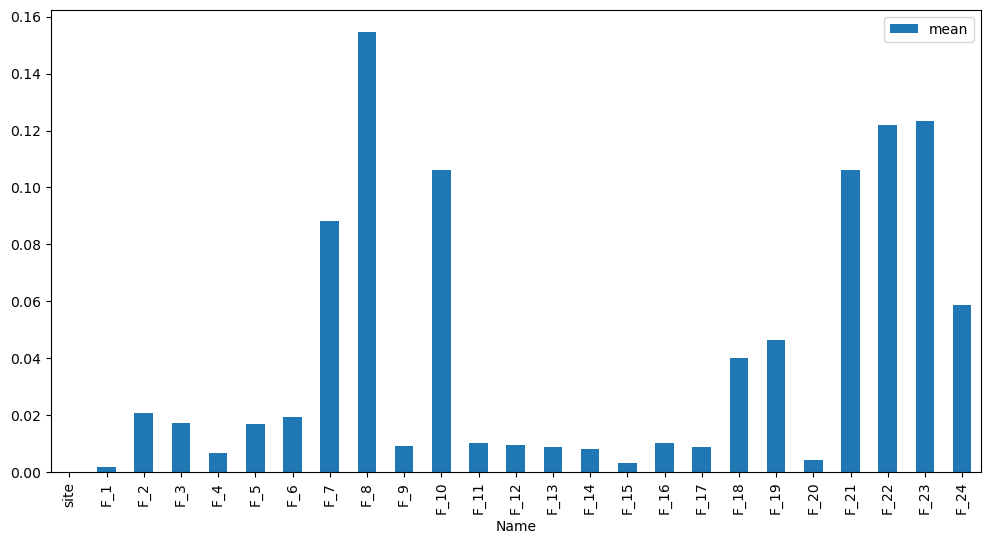

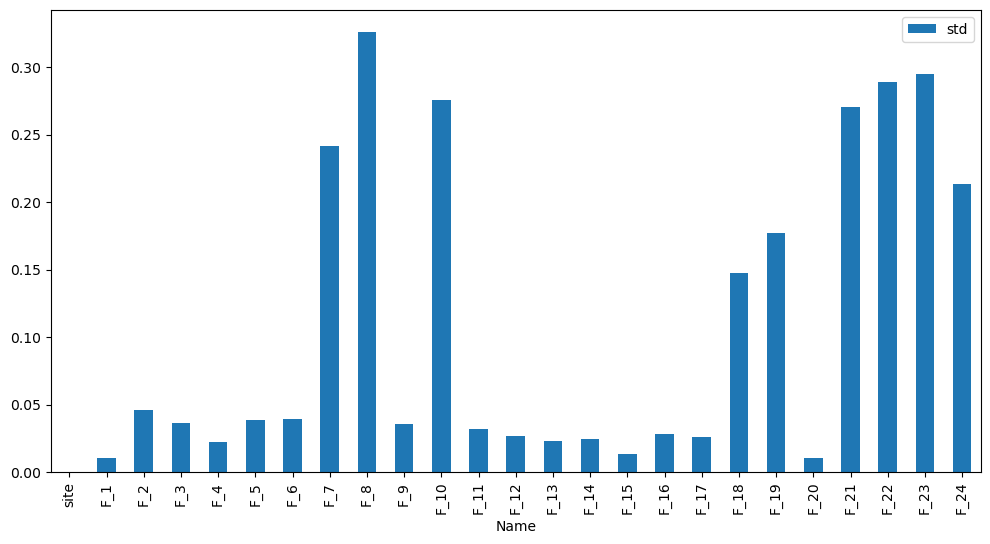

In [9]:
summary_data.plot(x='Name', y='mean', kind='bar', figsize=(12, 6))
summary_data.plot(x='Name', y='std', kind='bar', figsize=(12, 6))

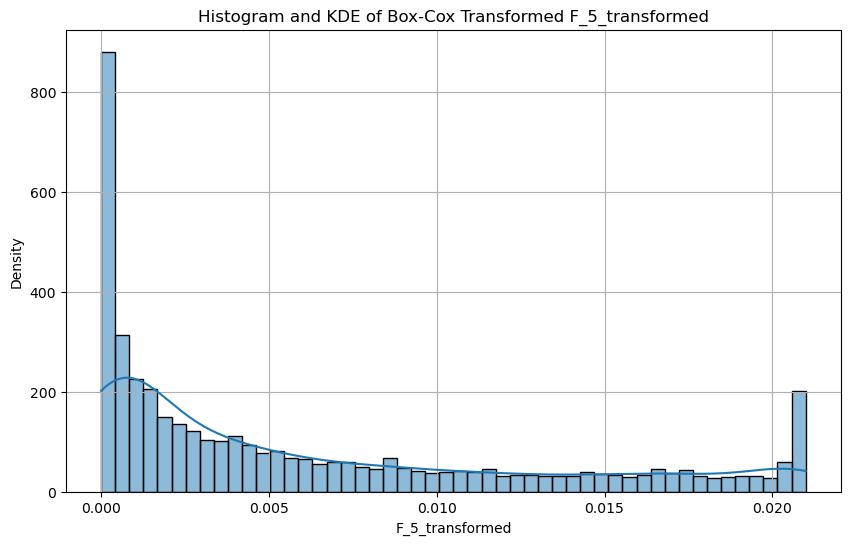

In [12]:
col = "F_5_transformed"
plt.figure(figsize=(10, 6))
sns.histplot(data_tranformed[col], bins=50, kde=True)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Histogram and KDE of Box-Cox Transformed ' + col)
plt.grid(True)
plt.show()

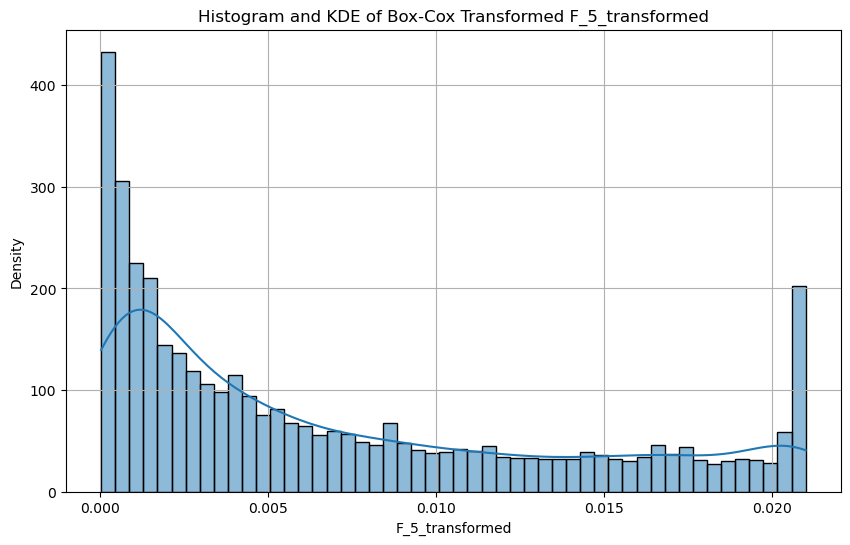

In [13]:
col = "F_5_transformed"
plt.figure(figsize=(10, 6))
sns.histplot(data_tranformed[col].loc[data_tranformed[col] > 0], bins=50, kde=True)
plt.xlabel(col)
plt.ylabel('Density')
plt.title('Histogram and KDE of Box-Cox Transformed ' + col)
plt.grid(True)
plt.show()

In [14]:
cols_features = pd.DataFrame()

for col in data_tranformed.columns[1:]:
    col_head = (
        data_tranformed[
            data_tranformed[col] >= data_tranformed[col].quantile(0.99)]
            # .sort_values(by=col, ascending=False)
            .head(20)
            .reset_index(drop=True)
    )["site"]
    cols_features = pd.concat([cols_features, pd.DataFrame({col : col_head})], axis=1)

cols_features

,F_1_transformed,F_2_transformed,F_3_transformed,F_4_transformed,F_5_transformed,F_6_transformed,F_7_transformed,F_8_transformed,F_9_transformed,F_10_transformed,...,F_15_transformed,F_16_transformed,F_17_transformed,F_18_transformed,F_19_transformed,F_20_transformed,F_21_transformed,F_22_transformed,F_23_transformed,F_24_transformed
0,i.imgur.com,npr.org,hotschedules.com,cchs.instructure.com,unrealengine.com,ladysavings.com,citizensbank.com,applebees.com,methstreams.me,wow-professions.com,...,sso.compassmanager.com,redstate.com,sellwellday.site,edition.cnn.com,petcarerx.com,leaffilterguards.com,coursehero.com,wtatennis.com,boards.cruisecritic.com,caredge.com
1,play.stmath.com,fark.com,rsa.choiceadvantage.com,byui.instructure.com,random.org,new.aldi.us,morningstar.com,theforkedspoon.com,vertvenvivo.net,mmo-champion.com,...,360.smg.com,upgrade.plusgrade.com,preferencecenter.hearstmags.com,miamiherald.com,forum.chronofhorse.com,cchs.instructure.com,apply.commonapp.org,nesn.com,oyster.com,quadratec.com
2,newgrounds.com,goodreads.com,login.vmcloudpms.com,trivia.greatergood.com,i.imgur.com,valpak.com,servicemessages.fidelity.com,foodandwine.com,racing.ustrotting.com,speedrun.com,...,secure06ea.chase.com,ftb.ca.gov,mc.beveragepromo.com,stltoday.com,zoetisus.com,link.springer.com,tpi.pearsoncmg.com,clevelandbrowns.com,swiss.com,clublexus.com
3,passes.com,nextmindtech.com,centraldispatch.com,thebreastcancersite.greatergood.com,verizon.com,lasvegas.craigslist.org,ibx.key.com,kitchensanctuary.com,1stream.me,warframe.fandom.com,...,applitrack.com,infowars.com,newport-pleasure.com,ajc.com,hepper.com,investingfuel.com,plus.pearson.com,behindthesteelcurtain.com,flynorse.com,autolist.com
4,loverslab.com,topnews-24.com,wifi.boingohotspot.net,thehungersite.greatergood.com,nvidia.com,sacramento.craigslist.org,cmegroup.com,theendlessmeal.com,sportsbookwire.usatoday.com,g2g.com,...,1point3acres.com,secure.login.gov,findkeep.love,mercurynews.com,wagwalking.com,app.zoom.us,studentscores.collegeboard.org,seahawks.com,viator.com,tiresize.com
5,sportsdesire.com,stream.directv.com,link.springer.com,azurestandard.com,otnolatrnup.com,checkout.ticketmaster.com,investor.vanguard.com,rasamalaysia.com,il.betrivers.com,fanatical.com,...,wifi.boingohotspot.net,usaa.com,bucketlisters.com,startribune.com,allivet.com,ontheworldmap.com,college.cengage.com,baseball-reference.com,icelandair.com,amsoil.com
6,kensaqsearch.com,gaiaonline.com,redweek.com,store.myfundraisingplace.com,bluestacks.com,scheels.com,www3.mtb.com,diethood.com,sportsbook.fanduel.com,lagged.com,...,egconnect.expedia.biz,benefitscal.com,roadrunnersports.com,mlive.com,pawrade.com,tabelog.com,ng.cengage.com,49ers.com,vacation.hotwire.com,autonation.com
7,patreon.com,pagesix.com,dnb.com,themahjong.com,webmail1.earthlink.net,kuiu.com,secure.bankofamerica.com,order.fiveguys.com,mc.beveragepromo.com,warcraftlogs.com,...,app.zoom.us,schengenvisainfo.com,ariat.com,nydailynews.com,statelinetack.com,choicehotelswifi.com,varsitytutors.com,cyclingnews.com,raileurope.com,toyota.com
8,todayshomelife.com,vgen.co,fsrsouth.myconnect.cc,renweb1.renweb.com,secure.logmein.com,classicfirearms.com,digital.fidelity.com,myrecipes.com,fubo.tv,snokido.com,...,careers.petsmart.com,pewresearch.org,xeroshoes.com,telegraph.co.uk,dogfoodadvisor.com,history.com,studocu.com,mtbr.com,vio.com,copilotsearch.com
9,redirect.euark.com,musiclab.chromeexperiments.com,mb.verizonwireless.com,cas.byu.edu,patents.google.com,leatherman.com,invest.ameritrade.com,natashaskitchen.com,livescore.com,rockpapershotgun.com,...,app.joinhandshake.com,edd.ca.gov,marlboro.com,nationalreview.com,marketplace.akc.org,thoughtco.com,mathway.com,fieldgulls.com,alamo.com,carparts.com


In [15]:
features_names = {
    'F_1_transformed' : "social_media", 
    'F_2_transformed' : "news_social", 
    'F_3_transformed' : "?",
    'F_4_transformed' : "health_lifestyle", 
    'F_5_transformed' : "tech/games", 
    'F_6_transformed' : "lifestyle",
    'F_7_transformed' : "finance", 
    'F_8_transformed' : "food", 
    'F_9_transformed' : "sport",
    'F_10_transformed' : "games", 
    'F_11_transformed' : "medical/health", 
    'F_12_transformed' : "guns",
    'F_13_transformed' : "natures", 
    'F_14_transformed' : "lifestyle_2", 
    'F_15_transformed' : "apps",
    'F_16_transformed' : "news_2",
    'F_17_transformed' : "sport/lifestyle",
    'F_18_transformed' : "news",
    'F_19_transformed' : "pets", 
    'F_20_transformed' : "accademy", 
    'F_21_transformed' : "courses",
    'F_22_transformed' : "sport", 
    'F_23_transformed' : "travel", 
    'F_24_transformed' : "cars"
    }

## Correlation

Num Cols: Index(['F_1_transformed', 'F_2_transformed', 'F_3_transformed',
       'F_4_transformed', 'F_5_transformed', 'F_6_transformed',
       'F_7_transformed', 'F_8_transformed', 'F_9_transformed',
       'F_10_transformed', 'F_11_transformed', 'F_12_transformed',
       'F_13_transformed', 'F_14_transformed', 'F_15_transformed',
       'F_16_transformed', 'F_17_transformed', 'F_18_transformed',
       'F_19_transformed', 'F_20_transformed', 'F_21_transformed',
       'F_22_transformed', 'F_23_transformed', 'F_24_transformed'],
      dtype='object')


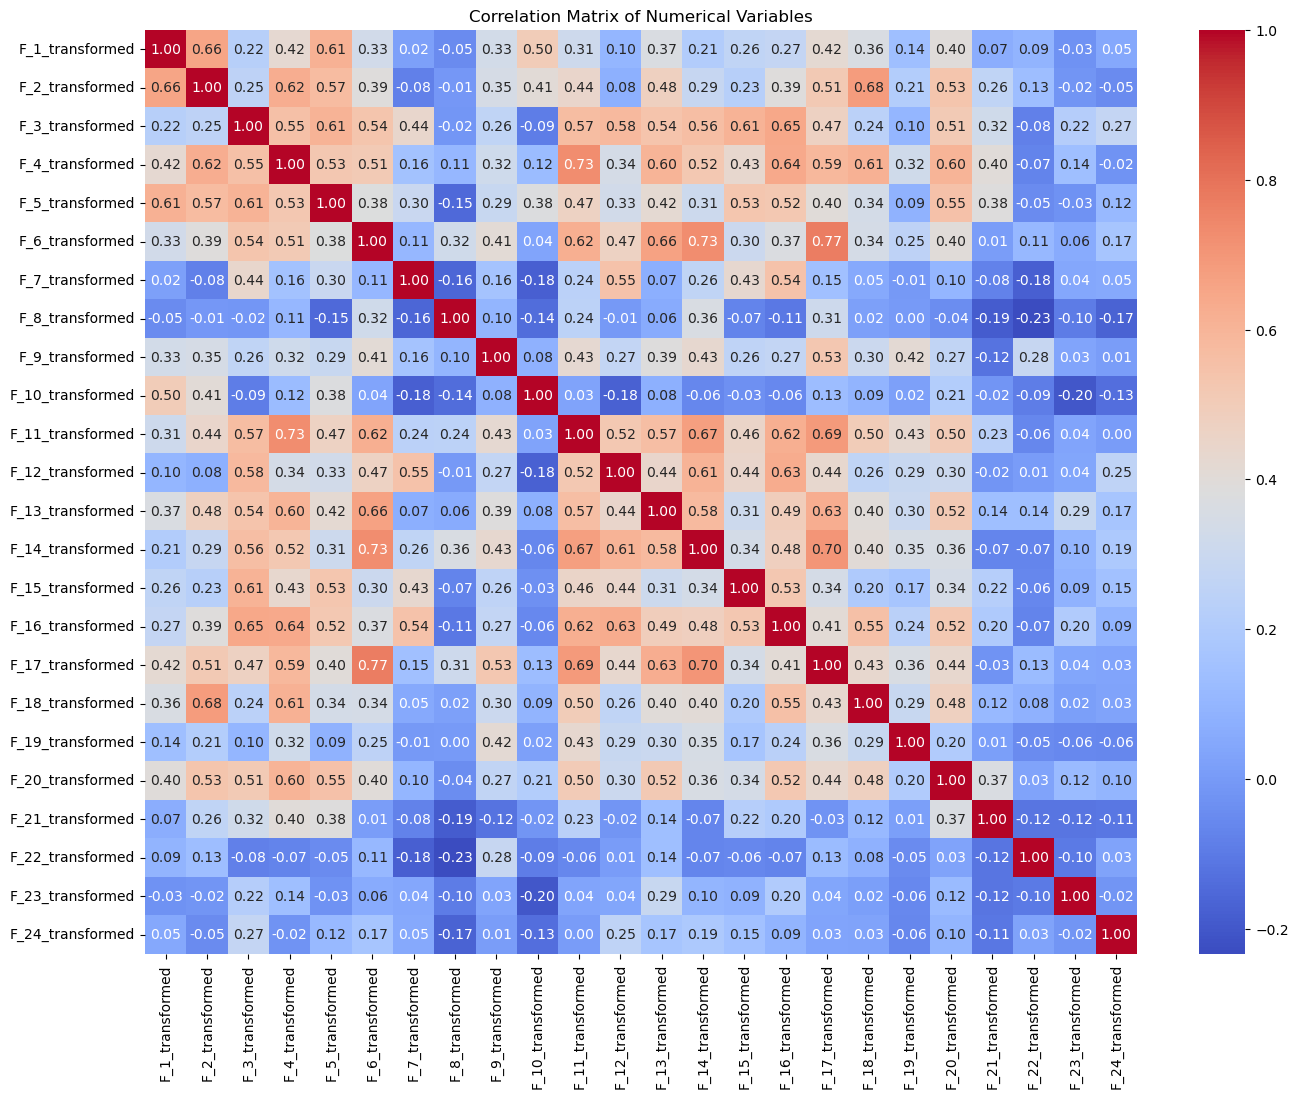

In [16]:
# Select numerical columns
numerical_cols = data_tranformed.columns[data_tranformed.columns.str.contains("_transformed")]
print("Num Cols: " + str(numerical_cols))
numerical_df = data_tranformed[numerical_cols]
corr_matrix = numerical_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## PCA

/var/folders/tf/tzhjhrlj1_x14gcsq_wsn4580000gn/T/ipykernel_66850/3980141339.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis')


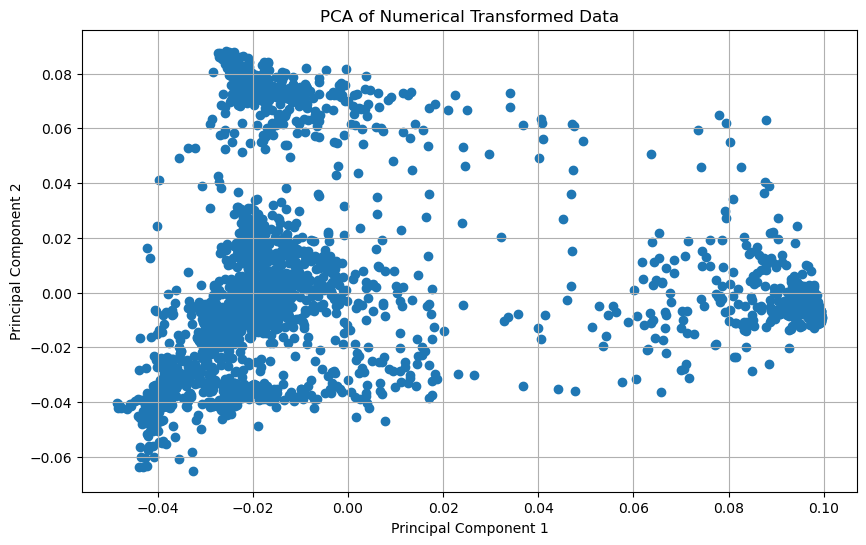

In [17]:
##%% PCA
numerical_cols = data_tranformed.columns.difference(["site"])
numerical_df = data_tranformed[numerical_cols]

pca = PCA(n_components=4) 
principal_components = pca.fit_transform(numerical_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Numerical Transformed Data')
plt.grid(True)
plt.show()


In [18]:
# 3D plot on Transformed Data

numerical_cols = data_tranformed.columns.difference(["site"])
numerical_df = data_tranformed[numerical_cols]

pca = PCA(n_components=4)
principal_components = pca.fit_transform(numerical_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

x_col = 'PC1'
y_col = 'PC2'
z_col = 'PC3'

fig = px.scatter_3d(pca_df, x=x_col, y=y_col, z=z_col, color=z_col,
                    title=f'3D Scatter Plot of {x_col} vs {y_col} vs {z_col}')
fig.update_layout(width=1000, height=800)
fig.show()

## T-SNE

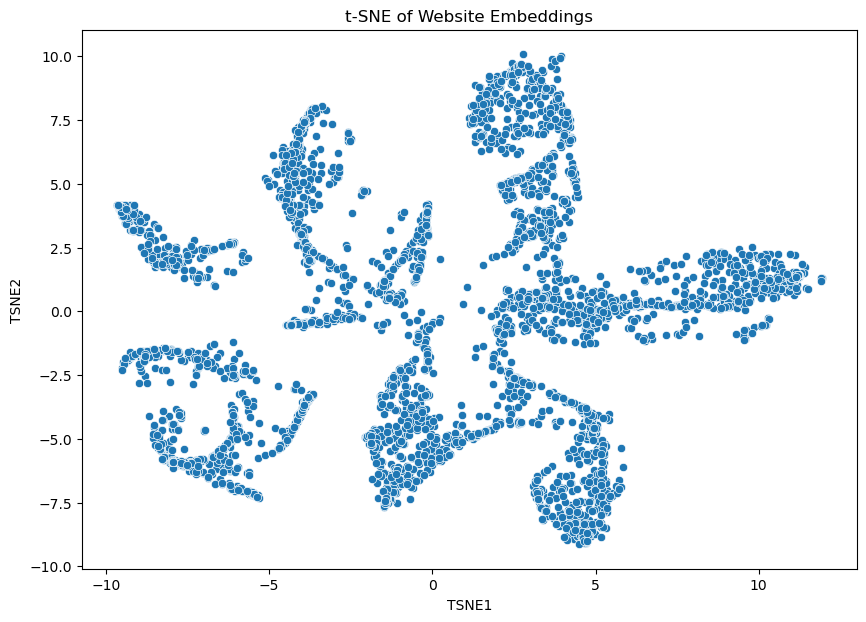

In [19]:
# t-SNE
df = data_tranformed.copy()
tsne = TSNE(n_components=2, perplexity=100, max_iter=300)
tsne_result = tsne.fit_transform(df.iloc[:, 1:])
df['TSNE1'] = tsne_result[:, 0]
df['TSNE2'] = tsne_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE1', y='TSNE2', data=df)
plt.title('t-SNE of Website Embeddings')
plt.show()

In [20]:
# t-SNE
df = data_tranformed.copy()
tsne = TSNE(n_components=3, perplexity=100, max_iter=300)
tsne_result = tsne.fit_transform(df.iloc[:, 1:])

df['TSNE1'] = tsne_result[:, 0]
df['TSNE2'] = tsne_result[:, 1]
df['TSNE3'] = tsne_result[:, 2]

x_col = 'TSNE1'
y_col = 'TSNE2'
z_col = 'TSNE3'

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(df, x=x_col, y=y_col, z=z_col, color=z_col,
                    title=f'3D Scatter Plot of {x_col} vs {y_col} vs {z_col}')

fig.update_layout(width=1000, height=800)

# Show the plot
fig.show()

## K-Meams

In [29]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

class WordEmbeddingClustering:
    """
    A class for clustering word embeddings from a pandas DataFrame where
    the first column contains the words.
    """

    def __init__(self, embedding_df: pd.DataFrame):
        """
        Initialize with the embedding DataFrame.

        Parameters:
        -----------
        embedding_df : pd.DataFrame
            DataFrame where the first column is the word and the remaining columns are embedding dimensions.
        """
        self.embedding_df = embedding_df
        self.words = embedding_df.iloc[:, 0].tolist()
        self.embeddings = embedding_df.iloc[:, 1:].values
        self.normalized_embeddings = self.embeddings
        self.labels_ = None
        self.model = None

    def cluster_embeddings(self, method: str = 'kmeans', n_clusters: int = 10, **kwargs):
        """
        Perform clustering on the normalized embeddings.

        Parameters:
        -----------
        method : str
            Clustering algorithm ('kmeans', 'dbscan', or 'gmm').
        n_clusters : int
            Number of clusters (used for 'kmeans' and 'gmm').
        """
        if method == 'kmeans':
            self.model = KMeans(n_clusters=n_clusters, **kwargs)
        elif method == 'dbscan':
            self.model = DBSCAN(**kwargs)
        elif method == 'gmm':
            self.model = GaussianMixture(n_components=n_clusters, **kwargs)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        self.labels_ = self.model.fit_predict(self.normalized_embeddings)
        self.labels_series = pd.Series(self.labels_, index=self.words, name='cluster')

    def get_cluster_words(self, n_words_per_cluster: int = 5):
        """
        Get representative words for each cluster.

        Parameters:
        -----------
        n_words_per_cluster : int
            Number of words per cluster to return.

        Returns:
        --------
        Dict[int, pd.DataFrame]
            Mapping of cluster labels to DataFrames of representative words.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        cluster_words = {}
        unique_labels = np.unique(self.labels_)
        
        for label in unique_labels:
            if label == -1:
                continue  # Skip noise points
            cluster_indices = np.where(self.labels_ == label)[0]
            cluster_embeddings = self.embeddings[cluster_indices]
            cluster_words_list = [self.words[idx] for idx in cluster_indices]
            cluster_df = pd.DataFrame(cluster_embeddings, index=cluster_words_list)

            if hasattr(self.model, 'cluster_centers_'):
                center = self.model.cluster_centers_[label]
            elif hasattr(self.model, 'means_'):
                center = self.model.means_[label]
            else:
                center = cluster_embeddings.mean(axis=0)
            
            distances = np.linalg.norm(cluster_embeddings - center, axis=1)
            closest_indices = np.argsort(distances)[:n_words_per_cluster]
            representative_words = cluster_df.iloc[closest_indices]
            cluster_words[label] = representative_words
            
        return cluster_words

    def get_cluster_statistics(self):
        """
        Calculate basic statistics for each cluster.

        Returns:
        --------
        pd.DataFrame
            DataFrame with cluster statistics.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        stats = []
        unique_labels = np.unique(self.labels_)
        
        for label in unique_labels:
            if label == -1:
                continue
            cluster_size = np.sum(self.labels_ == label)
            stats.append({
                'cluster': label,
                'size': cluster_size
            })
        
        return pd.DataFrame(stats).set_index('cluster')

    def evaluate_clustering(self):
        """
        Evaluate clustering using Silhouette Score and Davies-Bouldin Index,
        and provide per-cluster silhouette scores.

        Returns:
        --------
        Dict[str, Any]
            Dictionary with evaluation metrics, including per-cluster silhouette scores.
        """
        if self.labels_ is None:
            raise ValueError("Clustering has not been performed yet.")
        
        unique_labels = np.unique(self.labels_)
        if len(unique_labels) > 1:
            # Compute silhouette scores for all samples
            sample_silhouette_values = silhouette_samples(self.normalized_embeddings, self.labels_)
            # Overall silhouette score
            sil_score = sample_silhouette_values.mean()
            # Per-cluster silhouette scores
            cluster_silhouette_scores = {}
            for label in unique_labels:
                if label == -1:  # Skip noise points if using DBSCAN
                    continue
                cluster_mask = self.labels_ == label
                cluster_silhouette = sample_silhouette_values[cluster_mask].mean()
                cluster_silhouette_scores[label] = cluster_silhouette
            # Davies-Bouldin Index
            db_score = davies_bouldin_score(self.normalized_embeddings, self.labels_)
        else:
            sil_score = 0.0
            db_score = 0.0
            cluster_silhouette_scores = {label: 0.0 for label in unique_labels}
        
        return {
            'silhouette_score': sil_score,
            'davies_bouldin_index': db_score,
            'cluster_silhouette_scores': cluster_silhouette_scores
        }
    
    def find_optimal_clusters(self, k_range):
        from sklearn.metrics import silhouette_score, davies_bouldin_score

        wcss = []
        silhouette_scores = []
        db_scores = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.normalized_embeddings)
            wcss.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.normalized_embeddings, labels))
            db_scores.append(davies_bouldin_score(self.normalized_embeddings, labels))
        
        metrics = {
            'k_values': list(k_range),
            'wcss': wcss,
            'silhouette_scores': silhouette_scores,
            'davies_bouldin_scores': db_scores
        }
        return metrics

    def plot_k_distance(self, k=5):
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors_fit = neighbors.fit(self.normalized_embeddings)
        distances, indices = neighbors_fit.kneighbors(self.normalized_embeddings)
        distances = np.sort(distances[:, k-1], axis=0)
        plt.figure(figsize=(8, 5))
        plt.plot(distances)
        plt.xlabel('Data Points sorted by distance')
        plt.ylabel(f'{k}th Nearest Neighbor Distance')
        plt.title('Elbow Method For Optimal eps')
        plt.show()

## KMEANS

In [22]:
clusterer = WordEmbeddingClustering(data_tranformed)
clusterer.cluster_embeddings(
    method='kmeans',
    n_clusters=7, 
    # eps=0.04,        # for DBSCAN
    # min_samples=100   # for DBSCAN
)

evaluation = clusterer.evaluate_clustering()
print("\nClustering Evaluation:")
print(pd.DataFrame(evaluation, index=['value']).T)
print("----"*20)
print(pd.DataFrame.from_dict(evaluation["cluster_silhouette_scores"], orient='index', columns=['silhouette_score']))

labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Number of clusters found: {n_clusters}')


Clustering Evaluation:
                              value
silhouette_score           0.514276
davies_bouldin_index       1.145014
cluster_silhouette_scores       NaN
--------------------------------------------------------------------------------
   silhouette_score
0          0.097999
1          0.646448
2          0.238206
3          0.597192
4          0.698666
5          0.638255
6          0.611288
Number of clusters found: 7


Example of website per cluster

In [23]:
pd_webs = []

for i in range(7):
    pd_webs.append(clusterer.labels_series[clusterer.labels_series == i].head(20).index)
pd.DataFrame(pd_webs).T

,0,1,2,3,4,5,6
0,npr.org,login.ufl.edu,petcarerx.com,travelandleisure.com,ladysavings.com,redditmlbstreams.live,signin.att.com
1,thepetitionsite.com,slidesgo.com,legacy.curseforge.com,costcotravel.com,belleofthekitchen.com,govx.com,citiretailservices.citibankonline.com
2,cf.org,uc.instructure.com,forum.chronofhorse.com,rsa.choiceadvantage.com,api.kroger.com,texassports.com,citizensbank.com
3,order.preparedhero.com,nshe-unlv.okta.com,mapgenie.io,motel6.com,sso.compassmanager.com,tsn.ca,portal.discover.com
4,leaffilterguards.com,artofproblemsolving.com,wow-professions.com,new.mta.info,hy-vee.com,scorebooklive.com,eetd2.adp.com
5,nicenews.com,uvu.instructure.com,fark.com,rvshare.com,goldbelly.com,wtatennis.com,www1.deltadentalins.com
6,kidadl.com,livescience.com,unrealengine.com,travelocity.com,juliasalbum.com,watchprowrestling.co,secure05ea.chase.com
7,searchfavorites.net,canvas.csun.edu,pokemon.com,royalcaribbean.com,jerseymikes.com,sherdog.com,dmsapp.dealercenter.net
8,denver.craigslist.org,ublearns.buffalo.edu,abc7chicago.com,travel.delta.com,hotschedules.com,methstreams.me,foragentsonly.com
9,historicalgenius.com,lausd.org,discounttire.com,bookings.travelclick.com,pizzahut.com,forums.rivals.com,signin.travelers.com


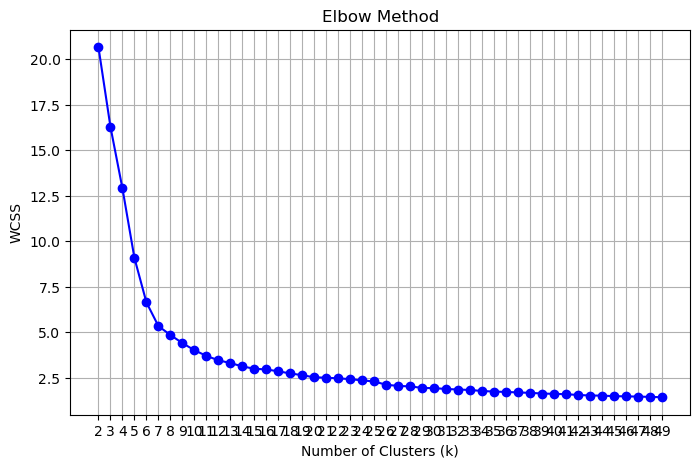

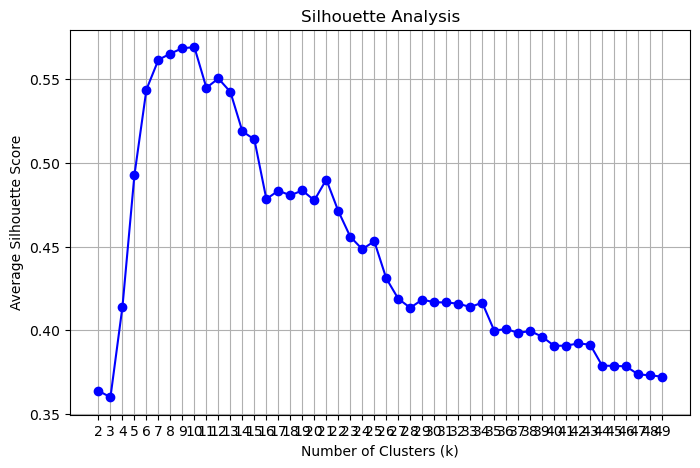

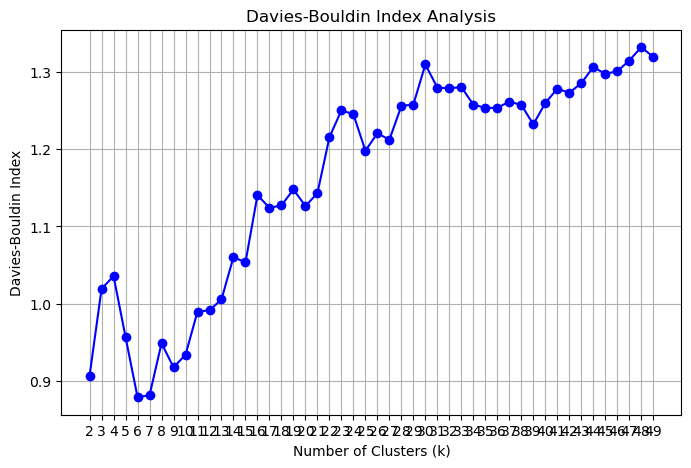

In [24]:
k_range = range(2, 50)

# Find optimal clusters
metrics = clusterer.find_optimal_clusters(k_range)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['wcss'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

# Plot Silhouette Analysis
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['silhouette_scores'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 5))
plt.plot(metrics['k_values'], metrics['davies_bouldin_scores'], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Analysis')
plt.xticks(metrics['k_values'])
plt.grid(True)
plt.show()

## DBSCAN

In [51]:
clusterer = WordEmbeddingClustering(data_tranformed)
clusterer.cluster_embeddings(
    method='dbscan',
    # n_clusters=10, 
    metric='cosine',
    eps=0.07,        # for DBSCAN
    min_samples=100   # for DBSCAN
)

evaluation = clusterer.evaluate_clustering()
print("\nClustering Evaluation:")
print(pd.DataFrame(evaluation, index=['value']).T)
print("----"*20)
print(pd.DataFrame.from_dict(evaluation["cluster_silhouette_scores"], orient='index', columns=['silhouette_score']))

labels = clusterer.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Number of clusters found: {n_clusters}')


Clustering Evaluation:
                              value
silhouette_score           0.545919
davies_bouldin_index       1.023609
cluster_silhouette_scores       NaN
--------------------------------------------------------------------------------
   silhouette_score
0          0.636129
1          0.698169
2          0.656816
3          0.680258
4          0.610410
5          0.686664
6          0.776835
Number of clusters found: 7


In [52]:
pd_webs = []

for i in clusterer.labels_series.unique():
    pd_webs.append(clusterer.labels_series[clusterer.labels_series == i].head(20).index)
pd_webs_df = pd.DataFrame(pd_webs).T
pd_webs_df.columns = clusterer.labels_series.unique()
pd_webs_df

,0,1,-1,2,3,4,5,6
0,redditmlbstreams.live,ladysavings.com,petcarerx.com,login.ufl.edu,signin.att.com,travelandleisure.com,legacy.curseforge.com,discounttire.com
1,govx.com,belleofthekitchen.com,npr.org,slidesgo.com,citiretailservices.citibankonline.com,costcotravel.com,mapgenie.io,imotors.com
2,texassports.com,api.kroger.com,forum.chronofhorse.com,uc.instructure.com,citizensbank.com,rsa.choiceadvantage.com,wow-professions.com,napaonline.com
3,tsn.ca,sso.compassmanager.com,thepetitionsite.com,nshe-unlv.okta.com,portal.discover.com,motel6.com,unrealengine.com,caredge.com
4,scorebooklive.com,hy-vee.com,fark.com,artofproblemsolving.com,eetd2.adp.com,new.mta.info,pokemon.com,bobistheoilguy.com
5,wtatennis.com,goldbelly.com,cf.org,uvu.instructure.com,www1.deltadentalins.com,rvshare.com,1v1.lol,goodyear.com
6,watchprowrestling.co,juliasalbum.com,order.preparedhero.com,livescience.com,secure05ea.chase.com,travelocity.com,pokemondb.net,fordtechservice.dealerconnection.com
7,sherdog.com,jerseymikes.com,abc7chicago.com,canvas.csun.edu,foragentsonly.com,royalcaribbean.com,answers.ea.com,cycletrader.com
8,methstreams.me,hotschedules.com,leaffilterguards.com,ublearns.buffalo.edu,signin.travelers.com,travel.delta.com,dndbeyond.com,quadratec.com
9,forums.rivals.com,pizzahut.com,zoetisus.com,lausd.org,fool.com,bookings.travelclick.com,game8.co,volvocars.com


In [38]:
eps_values = np.arange(0.01, 0.071, 0.01)
min_samples_values = range(100, 701, 100)

sil_metrics = []
dbi_metrics = []
params = []

for eps in eps_values:
    # print("_____"*20)
    for min_samples in min_samples_values:
        clusterer.cluster_embeddings(method='dbscan', eps=eps, min_samples=min_samples, metric='cosine')
        labels = clusterer.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f'eps={eps}, min_samples={min_samples}, clusters={n_clusters}, noise points={n_noise}')
        
        evaluation = clusterer.evaluate_clustering()
        # print("\nClustering Evaluation:")
        # print(pd.DataFrame(evaluation, index=['value']).T)
        sil_metrics.append(evaluation["silhouette_score"])
        dbi_metrics.append(evaluation["davies_bouldin_index"])
        params.append((eps, min_samples, n_clusters, n_noise))
        

A = pd.DataFrame([params, sil_metrics, dbi_metrics]).T
A.columns = ["params", "silhouette_score", "davies_bouldin_index"]
A = A.loc[~(A["silhouette_score"] == 0.0)]

fig = px.scatter(A, x="davies_bouldin_index", y="silhouette_score", title="Davies-Bouldin Index vs Silhouette Score")
fig.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridcolor='black'), yaxis=dict(showgrid=True, gridcolor='black'))
fig.show()


eps=0.01, min_samples=100, clusters=6, noise points=2435
eps=0.01, min_samples=200, clusters=4, noise points=2903
eps=0.01, min_samples=300, clusters=1, noise points=3793
eps=0.01, min_samples=400, clusters=1, noise points=3795
eps=0.01, min_samples=500, clusters=0, noise points=4298
eps=0.01, min_samples=600, clusters=0, noise points=4298
eps=0.01, min_samples=700, clusters=0, noise points=4298
eps=0.02, min_samples=100, clusters=7, noise points=1670
eps=0.02, min_samples=200, clusters=6, noise points=1956
eps=0.02, min_samples=300, clusters=3, noise points=2955
eps=0.02, min_samples=400, clusters=1, noise points=3678
eps=0.02, min_samples=500, clusters=1, noise points=3684
eps=0.02, min_samples=600, clusters=0, noise points=4298
eps=0.02, min_samples=700, clusters=0, noise points=4298
eps=0.03, min_samples=100, clusters=7, noise points=1358
eps=0.03, min_samples=200, clusters=6, noise points=1630
eps=0.03, min_samples=300, clusters=5, noise points=2027
eps=0.03, min_samples=400, clus

In [44]:
pd.DataFrame(params, columns=["eps", "min_samples", "clusters", "noise"]).sort_values(by = "noise", ascending=True)

,eps,min_samples,clusters,noise
42,0.07,100,7,682
35,0.06,100,7,831
28,0.05,100,7,944
43,0.07,200,6,1001
44,0.07,300,6,1064
21,0.04,100,7,1103
36,0.06,200,6,1119
37,0.06,300,6,1187
29,0.05,200,6,1245
30,0.05,300,6,1315


## Similarity Matrix

In [53]:
# Provedení analýzy
results = analyze_web_similarity(data_tranformed)

In [55]:
pd.DataFrame(results["similarity_dict"]["wine.com"])

,web,cosine_similarity,euclidean_distance,jaccard_sim
0,atlanta.eater.com,0.999959,0.001095,0.979224
1,bjsrestaurants.com,0.999952,0.001174,0.979078
2,media-cdn.getbento.com,0.999920,0.001521,0.972514
3,chicago.eater.com,0.999895,0.001744,0.964613
4,eatwell101.com,0.999871,0.001934,0.976109


# Analyza Nul

In [33]:
nuly = data_tranformed.copy()

In [80]:
maska_nul = nuly == 0
nuly[maska_nul] = 1
nuly[~maska_nul] = 0

Slopce, ktery korelujou svyma nulama a zbytekem jsou pravdepodobne pocet navstevnosti a delka stravena na strance.

Jeste se podivame na Jaccardovu podobnost nul

In [167]:
from sklearn.metrics import pairwise_distances

# Compute Jaccard distance for all rows
jaccard_distances = pairwise_distances(nuly.drop("site", axis=1).values, metric="jaccard")

# Convert distance to similarity (1 - distance)
jaccard_similarities = 1 - jaccard_distances

# Create a similarity DataFrame
similarity_jaccard_df = pd.DataFrame(jaccard_similarities, index=nuly.drop("site", axis=1).index, columns=nuly.drop("site", axis=1).index)

print(similarity_jaccard_df)


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2350: DataConversionWarning:

Data was converted to boolean for metric jaccard



          0         1         2         3         4         5         6     \
0     1.000000  0.666667  0.166667  0.727273  0.294118  0.333333  0.583333   
1     0.666667  1.000000  0.157895  0.772727  0.210526  0.450000  0.695652   
2     0.166667  0.157895  1.000000  0.190476  0.285714  0.250000  0.136364   
3     0.727273  0.772727  0.190476  1.000000  0.238095  0.454545  0.826087   
4     0.294118  0.210526  0.285714  0.238095  1.000000  0.333333  0.238095   
...        ...       ...       ...       ...       ...       ...       ...   
4293  0.708333  0.750000  0.166667  0.875000  0.208333  0.458333  0.875000   
4294  0.619048  0.666667  0.166667  0.809524  0.294118  0.555556  0.727273   
4295  0.250000  0.300000  0.090909  0.380952  0.181818  0.461538  0.380952   
4296  0.235294  0.157895  0.333333  0.190476  0.500000  0.250000  0.190476   
4297  0.608696  0.727273  0.142857  0.863636  0.250000  0.550000  0.863636   

          7         8         9     ...      4288      4289    

In [168]:
similarity_dict = {}
n_similar = 5
for i, website in enumerate(data_tranformed["site"]):
    # Najdeme nejpodobnější stránky (kromě sebe sama)
    similar_indices = similarity_jaccard_df[i].argsort()[::-1][1:n_similar+1]
    similar_websites = [
        {
            'web': data_tranformed["site"].iloc[idx],
            'jaccard_similarity': similarity_jaccard_df[i][idx]
        }
        for idx in similar_indices
    ]
    similarity_dict[website] = similar_websites

In [169]:
similarity_dict["wine.com"] 

[{'web': 'twopeasandtheirpod.com', 'jaccard_similarity': 0.75},
 {'web': 'eatwell101.com', 'jaccard_similarity': 0.7142857142857143},
 {'web': 'momontimeout.com', 'jaccard_similarity': 0.7142857142857143},
 {'web': 'jamesonwhiskey.com', 'jaccard_similarity': 0.6666666666666667},
 {'web': 'skinnytaste.com', 'jaccard_similarity': 0.6666666666666667}]

# Dalsi kroky

* H2O automl pro clustering
  